In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[7.1611e-08, 8.5144e-16, 3.2632e-15, 2.2417e-11, 5.3009e-15, 5.2489e-16,
          5.3625e-06, 1.0780e-10, 9.9999e-01, 3.9217e-11]]),
 tensor([[3.2217e-02, 8.3775e-04, 1.0960e-03, 6.4150e-03, 1.2077e-03, 7.6050e-04,
          7.6376e-02, 8.7823e-03, 8.6513e-01, 7.1743e-03]]),
 tensor([[0.1015, 0.0164, 0.0187, 0.0453, 0.0196, 0.0156, 0.1562, 0.0530, 0.5258,
          0.0479]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

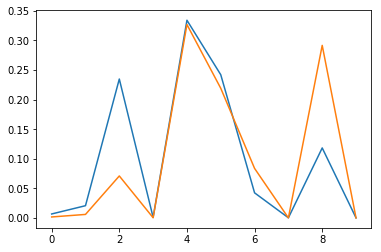

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
#export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model
    Runs but doesn't reproduce paper results; values are off and display strong changes between benchmarks
    Includes option to randomise params per batch, but results in worse performance'''
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)  #  Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[0] = self.true_mu  # POI set to true value
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.b_mask = self.wrapper.y.squeeze() == 0
        self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        f_s = to_shape(self.wrapper.y_pred[~self.b_mask])
        f_b = to_shape(self.wrapper.y_pred[self.b_mask])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

#export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[1]
        if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init

In [15]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [16]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1.h5'),EarlyStopping(10)])

1: Train=385.69261352539064 Valid=353.3756463623047
2: Train=347.76945739746094 Valid=338.3596209716797
3: Train=336.95336669921875 Valid=333.31912902832033
4: Train=331.0585482788086 Valid=329.6501690673828
5: Train=327.9644937133789 Valid=326.4810980224609
6: Train=324.4109115600586 Valid=323.1170861816406
7: Train=322.04845962524416 Valid=321.1775457763672
8: Train=319.3360592651367 Valid=319.11048828125
9: Train=316.9687432861328 Valid=316.6241058349609
10: Train=314.0364782714844 Valid=314.5552453613281
11: Train=312.0781730651855 Valid=312.01778198242187
12: Train=310.5304968261719 Valid=309.571572265625
13: Train=307.92865737915037 Valid=307.6109033203125
14: Train=305.25775146484375 Valid=305.67315185546875
15: Train=303.0194903564453 Valid=303.6714764404297
16: Train=301.24136276245116 Valid=301.46715881347654
17: Train=298.8051652526855 Valid=298.9347540283203
18: Train=297.0845590209961 Valid=297.7735833740234
19: Train=294.7507073974609 Valid=295.76795654296876
20: Train=29

156: Train=245.58742126464844 Valid=247.9686422729492
157: Train=245.10723526000976 Valid=248.4753091430664
158: Train=245.11431518554687 Valid=247.6878790283203
159: Train=245.4772283935547 Valid=247.84910217285156
160: Train=244.68829559326173 Valid=247.60855865478516
161: Train=245.00799270629884 Valid=247.41626342773438
162: Train=244.97802368164062 Valid=247.69666015625
163: Train=244.58596771240235 Valid=247.9364599609375
164: Train=244.58568878173827 Valid=247.8694338989258
165: Train=245.2146746826172 Valid=247.1975942993164
166: Train=245.00398696899413 Valid=247.45624114990235
167: Train=244.5960089111328 Valid=247.4521875
168: Train=244.5432078552246 Valid=247.4125833129883
169: Train=244.41176788330077 Valid=247.34314056396485
170: Train=244.4928761291504 Valid=247.29421844482422
171: Train=244.3788833618164 Valid=246.99345336914064
172: Train=244.91939422607422 Valid=246.8321905517578
173: Train=244.95653030395508 Valid=247.16846923828126
174: Train=244.69824325561524 Vali

In [17]:
model.save('weights/Inferno_Test_exact_bm1.h5')

In [18]:
model.load('weights/Inferno_Test_exact_bm1.h5')

# Results

In [19]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [20]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [21]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,1,1.0
1,8,1.0
2,2,1.0
3,8,1.0
4,6,1.0


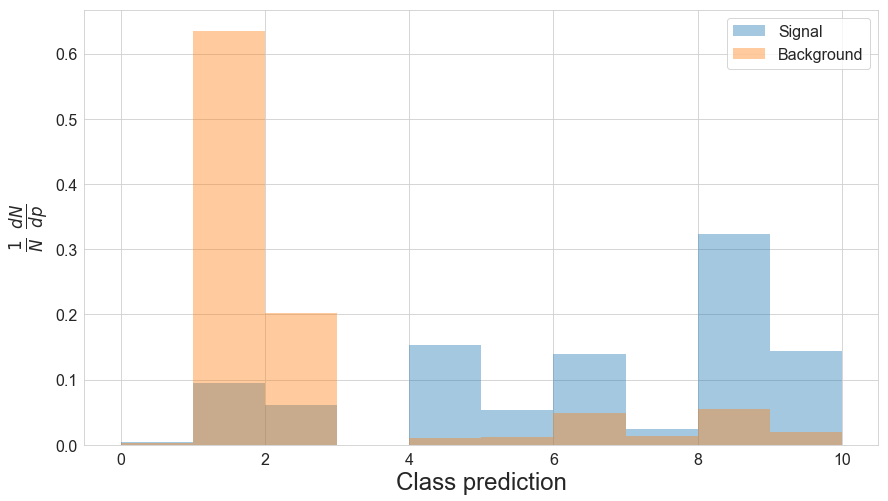

In [22]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [23]:
bin_preds(df)

In [24]:
df.head()

,pred,gen_target,pred_bin
0,1,1.0,1
1,8,1.0,8
2,2,1.0,2
3,8,1.0,8
4,6,1.0,6


In [25]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [26]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [27]:
f_s, f_b

(tensor([4.9560e-03, 9.4848e-02, 6.1576e-02, 2.0000e-13, 1.5283e-01, 5.3164e-02,
         1.3992e-01, 2.4622e-02, 3.2375e-01, 1.4433e-01]),
 tensor([3.2440e-03, 6.3527e-01, 2.0173e-01, 2.0000e-13, 9.6800e-03, 1.2232e-02,
         4.9128e-02, 1.4134e-02, 5.4786e-02, 1.9790e-02]))

In [28]:
asimov = (50*f_s)+(1000*f_b)

In [29]:
asimov, asimov.sum()

(tensor([3.4918e+00, 6.4002e+02, 2.0481e+02, 2.1000e-10, 1.7321e+01, 1.4890e+01,
         5.6124e+01, 1.5365e+01, 7.0973e+01, 2.7007e+01]), tensor(1050.))

In [30]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([26.92478752, 26.77406502, 26.62925529, 26.49089813, 26.35827637,
       26.23171234, 26.11070824, 25.9956913 , 25.88625526, 25.7823658 ,
       25.6839695 , 25.59152412, 25.50375366, 25.42116356, 25.34428596,
       25.27242661, 25.20588493, 25.14400291, 25.08692741, 25.03531647,
       24.98840332, 24.94583893, 24.90786743, 24.87507629, 24.84618378,
       24.82256699, 24.80314636, 24.78796387, 24.77720451, 24.77085304,
       24.76902962, 24.77095985, 24.77709961, 24.78745461, 24.80210114,
       24.82067299, 24.84315491, 24.86903   , 24.89992142, 24.9337101 ,
       24.9715538 , 25.01360893, 25.05872345, 25.10836792, 25.16101646,
       25.21720695, 25.27734375, 25.34128761, 25.40820312, 25.47838402,
       25.55223274, 25.63010597, 25.71057129, 25.79433632, 25.88210106,
       25.97261429, 26.0661602 , 26.16340828, 26.26395416, 26.36725426,
       26.47385025])

In [31]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [32]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

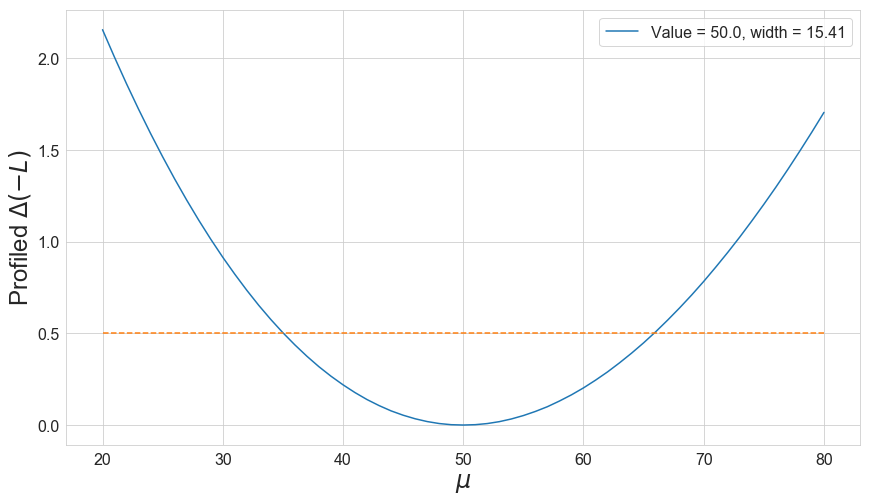

In [33]:
plot_likelihood(y-y.min())

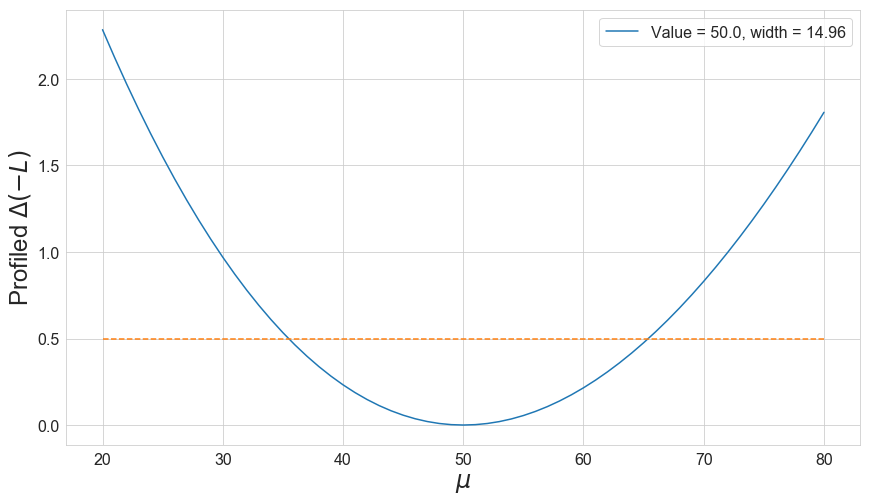

In [34]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [35]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [36]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [37]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,1,1.0,1,1,1,1,1,1,1,1,1,1,1
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,2,1.0,2,2,2,2,2,2,2,2,2,2,2
3,8,1.0,8,8,8,8,8,8,8,8,8,8,8
4,6,1.0,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,0.0,9,9,9,9,9,4,4,9,9,4,4
999996,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999997,6,0.0,6,6,6,6,6,1,1,6,6,6,6
999998,1,0.0,1,1,1,1,1,1,1,1,1,1,1


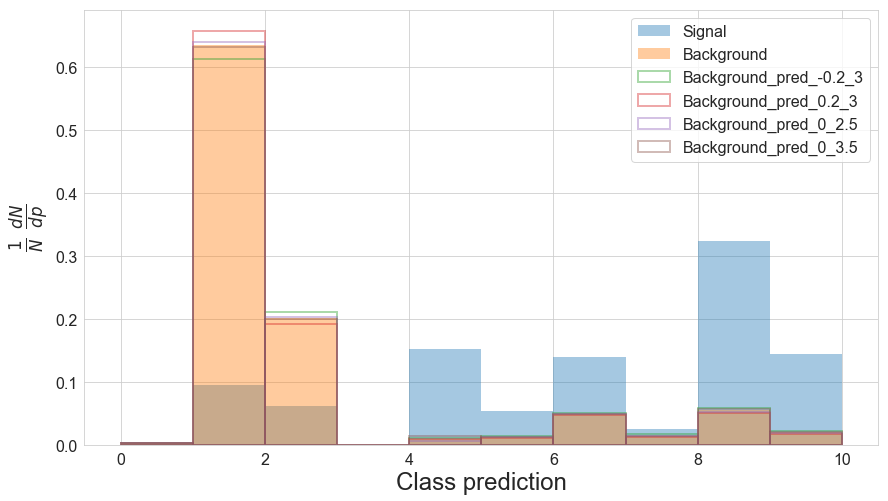

In [38]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([3.2080e-03, 6.1613e-01, 2.1285e-01, 2.0000e-13, 7.4220e-03, 1.3924e-02,
        5.1734e-02, 1.7316e-02, 5.5846e-02, 2.1566e-02])
tensor([3.3160e-03, 6.1237e-01, 2.1099e-01, 2.0000e-13, 1.0774e-02, 1.3672e-02,
        5.1180e-02, 1.6788e-02, 5.8666e-02, 2.2240e-02])
tensor([3.3340e-03, 6.0872e-01, 2.0916e-01, 2.0000e-13, 1.4960e-02, 1.3392e-02,
        5.0320e-02, 1.6250e-02, 6.1078e-02, 2.2788e-02])
tensor([3.1360e-03, 6.3904e-01, 2.0359e-01, 2.0000e-13, 6.3280e-03, 1.2484e-02,
        4.9682e-02, 1.4662e-02, 5.1966e-02, 1.9116e-02])
tensor([3.2440e-03, 6.3527e-01, 2.0173e-01, 2.0000e-13, 9.6800e-03, 1.2232e-02,
        4.9128e-02, 1.4134e-02, 5.4786e-02, 1.9790e-02])
tensor([3.2620e-03, 6.3162e-01, 1.9990e-01, 2.0000e-13, 1.3866e-02, 1.1952e-02,
        4.8268e-02, 1.3596e-02, 5.7198e-02, 2.0338e-02])
tensor([3.0120e-03, 6.6165e-01, 1.9422e-01, 2.0000e-13, 5.4480e-03, 1.1034e-02,
        4.7756e-02, 1.2278e-02, 4.7764e-02, 1.6836e-02])
tensor([3.1200e-03, 6.5789e-01, 1.9236e-0

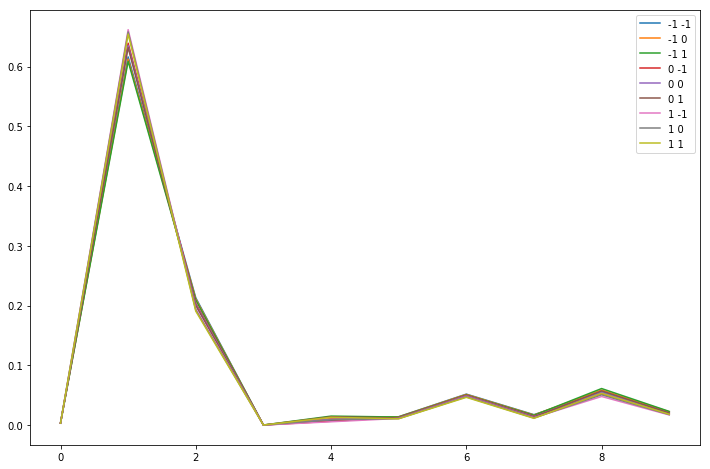

In [39]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [40]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [41]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [42]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [43]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [44]:
nll = to_np(nll)

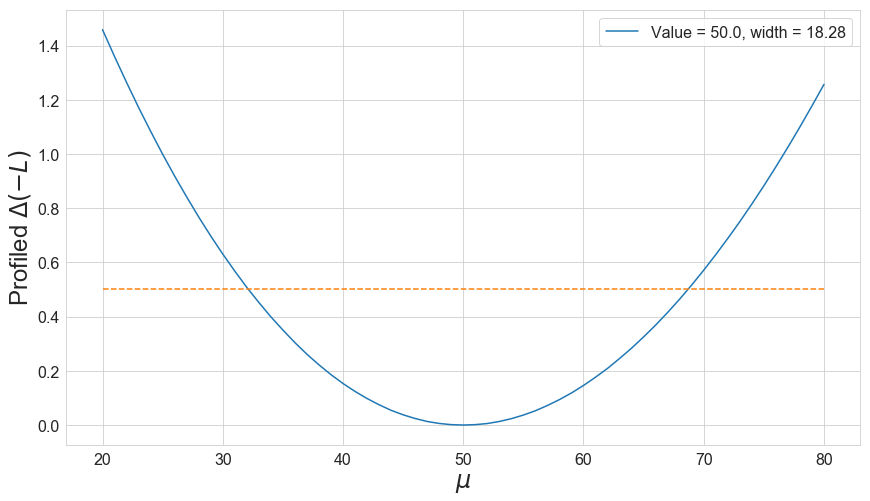

In [45]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [46]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [47]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.1810])
Linear regime: Mu 21.0, alpha tensor([1.1410])
Linear regime: Mu 22.0, alpha tensor([1.1011])
Linear regime: Mu 23.0, alpha tensor([1.0612])
Linear regime: Mu 70.0, alpha tensor([-1.0011])
Linear regime: Mu 71.0, alpha tensor([-1.0318])
Linear regime: Mu 72.0, alpha tensor([-1.0806])
Linear regime: Mu 73.0, alpha tensor([-1.1294])
Linear regime: Mu 74.0, alpha tensor([-1.1781])
Linear regime: Mu 75.0, alpha tensor([-1.2268])
Linear regime: Mu 76.0, alpha tensor([-1.2755])
Linear regime: Mu 77.0, alpha tensor([-1.3241])
Linear regime: Mu 78.0, alpha tensor([-1.3727])
Linear regime: Mu 79.0, alpha tensor([-1.4213])
Linear regime: Mu 80.0, alpha tensor([-1.4699])


In [48]:
nll = to_np(nll)

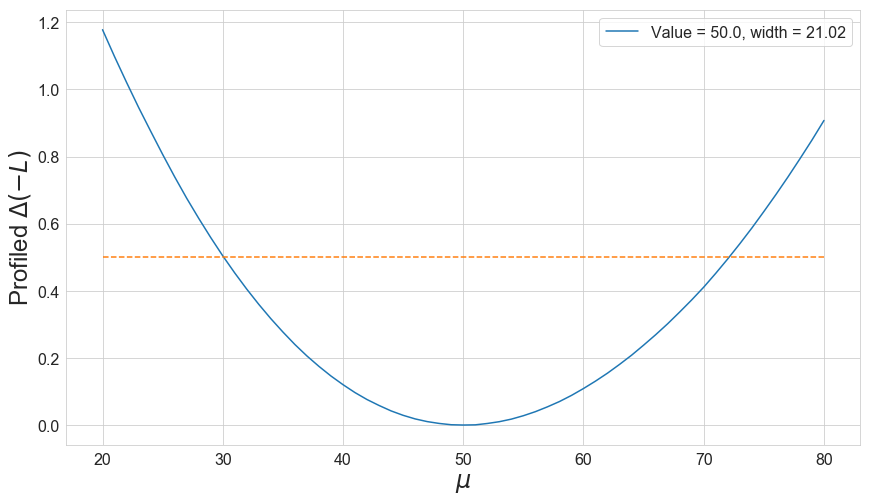

In [49]:
plot_likelihood(nll-nll.min())

## BM 2

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 73.0, alpha tensor([ 0.3769, -1.0006])
Linear regime: Mu 74.0, alpha tensor([ 0.3950, -1.0302])
Linear regime: Mu 75.0, alpha tensor([ 0.4112, -1.0730])
Linear regime: Mu 76.0, alpha tensor([ 0.4274, -1.1160])
Linear regime: Mu 77.0, alpha tensor([ 0.4436, -1.1589])
Linear regime: Mu 78.0, alpha tensor([ 0.4598, -1.2018])
Linear regime: Mu 79.0, alpha tensor([ 0.4760, -1.2447])
Linear regime: Mu 80.0, alpha tensor([ 0.4921, -1.2876])


In [51]:
nll = to_np(nll)

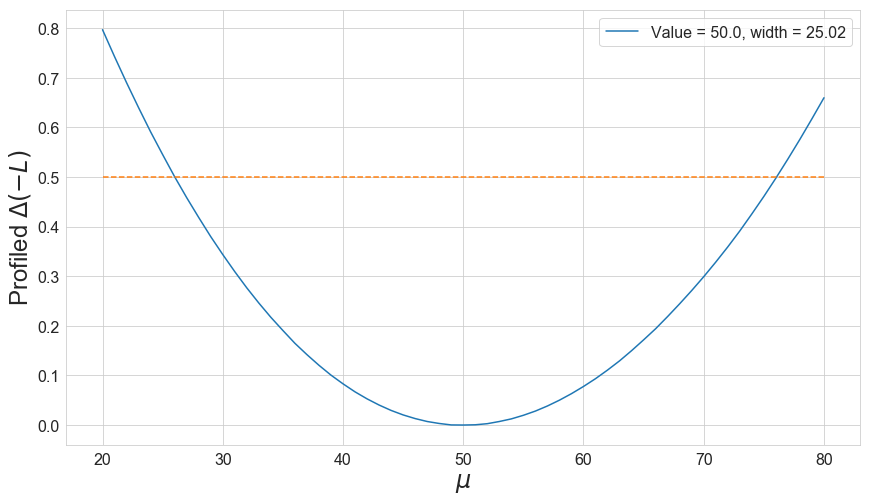

In [52]:
plot_likelihood(nll-nll.min())